In [345]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [347]:
# Load the data
df = pd.read_csv('Data/RedfinDataReadyData.csv')

In [351]:
df.head()

,SALE TYPE,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIPCODE,PRICE,BEDS,BATHS,LOCATION,GreatWaterViews,SQUARE FEET,LOT SIZE,YEAR BUILT,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE
0,PAST SALE,May-23-2025,Single Family Residential,1322 Palm Dr,Apopka,FL,32703,1355000,3,2.0,SUNSET SHORES REP OF LTS 4 5 & 6,1,2343,13351.0,1973.0,578,NaN,28.658867,-81.454199
1,PAST SALE,March-31-2025,Single Family Residential,3141 Oak Alley Dr,Apopka,FL,32703,1300000,4,3.0,OAK HILLS SUB,0,8875,90111.0,2007.0,146,16.0,28.632255,-81.505761
2,PAST SALE,May-7-2025,Single Family Residential,6115 Linneal Beach Dr,Apopka,FL,32703,1275000,4,2.0,BEAR LAKE ESTATES 1ST ADD,1,2551,57000.0,1991.0,500,NaN,28.646740,-81.455975
3,PAST SALE,April-15-2025,Single Family Residential,1526 Pinecliff Dr,Apopka,FL,32703,1256627,5,4.0,BRONSON PEAK PHASE 1A,0,3982,16230.0,2025.0,316,120.0,28.662070,-81.536138
4,PAST SALE,May-1-2025,Single Family Residential,5203 Pineview Way,Apopka,FL,32703,1200000,5,3.5,MC NEILS ORANGE VILLA,1,3540,339768.0,1973.0,339,NaN,28.646920,-81.437968


In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SALE TYPE          289 non-null    object 
 1   SOLD DATE          275 non-null    object 
 2   PROPERTY TYPE      289 non-null    object 
 3   ADDRESS            289 non-null    object 
 4   CITY               288 non-null    object 
 5   STATE OR PROVINCE  289 non-null    object 
 6   ZIPCODE            289 non-null    int64  
 7   PRICE              289 non-null    int64  
 8   BEDS               289 non-null    int64  
 9   BATHS              289 non-null    float64
 10  LOCATION           274 non-null    object 
 11  GreatWaterViews    289 non-null    int64  
 12  SQUARE FEET        289 non-null    int64  
 13  LOT SIZE           287 non-null    float64
 14  YEAR BUILT         288 non-null    float64
 15  $/SQUARE FEET      289 non-null    int64  
 16  HOA/MONTH          203 non

In [355]:
df['ZIPCODE'] = df['ZIPCODE'].astype('object')

In [357]:
df.groupby('ZIPCODE')['PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
ZIPCODE,,,,,,,,
32703,132.0,452290.651515,215807.662576,80000.0,333750.0,416490.0,520247.5,1355000.0
32712,151.0,463005.920530,122330.893761,171000.0,388000.0,443990.0,552500.0,800000.0
32776,1.0,307000.000000,NaN,307000.0,307000.0,307000.0,307000.0,307000.0
32798,3.0,369993.333333,190519.815330,150000.0,314995.0,479990.0,479990.0,479990.0
32832,1.0,375000.000000,NaN,375000.0,375000.0,375000.0,375000.0,375000.0
34761,1.0,475000.000000,NaN,475000.0,475000.0,475000.0,475000.0,475000.0


In [359]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   SALE TYPE          289 non-null    object 
 1   SOLD DATE          275 non-null    object 
 2   PROPERTY TYPE      289 non-null    object 
 3   ADDRESS            289 non-null    object 
 4   CITY               288 non-null    object 
 5   STATE OR PROVINCE  289 non-null    object 
 6   ZIPCODE            289 non-null    object 
 7   PRICE              289 non-null    int64  
 8   BEDS               289 non-null    int64  
 9   BATHS              289 non-null    float64
 10  LOCATION           274 non-null    object 
 11  GreatWaterViews    289 non-null    int64  
 12  SQUARE FEET        289 non-null    int64  
 13  LOT SIZE           287 non-null    float64
 14  YEAR BUILT         288 non-null    float64
 15  $/SQUARE FEET      289 non-null    int64  
 16  HOA/MONTH          203 non

### Random Forest Regression model for predicting sold prices.

In [362]:
# Function to train and predict for a specific position
def train_and_predict(position, features):
    # Filter data for the specific position
    position_data = df[df['ZIPCODE'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X and y
    X = position_data[features].fillna(0)
    y = position_data['PRICE'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Label split using true indices
    position_data.loc[idx_train, 'Data Split'] = 'Train'
    position_data.loc[idx_test, 'Data Split'] = 'Test'
    
    # Train the model
    rf = RandomForestRegressor(
        n_estimators=200, 
        max_depth=20, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    train_df = position_data.loc[idx_train, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'PredictedPrice'] = y_pred_train

    test_df = position_data.loc[idx_test, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'PredictedPrice'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True)

    # Predict the 2024 fantasy points
    position_data.loc[:, 'PredictedPrice'] = rf.predict(X)
    
    return position_data[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']]

# Define feature sets for each position, including past PPR points and new features
# Define feature sets for each position, including past PPR points and new features
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'GreatWaterViews']

# Train and predict for all ZIP codes automatically
# Only include ZIPs with 2 or more rows
valid_zips = df['ZIPCODE'].value_counts()
valid_zips = valid_zips[valid_zips >= 2].index

all_predictions_list = []

for position in valid_zips:
    prediction_df = train_and_predict(position, features)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

all_predictions = pd.concat(all_predictions_list, ignore_index=True).round(0)


# Save the projected data to a new CSV file in the Downloads directory, only including player name and predicted points
output_path = "Data/Redfin_Apopka.csv"
all_predictions[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)


32712 - Training MAE: 15799.404458333333
32712 - Testing MAE: 40713.49935483871

32712 - Feature Importances:
           Feature  Importance
2      SQUARE FEET    0.768839
3         LOT SIZE    0.061720
4       YEAR BUILT    0.054187
1            BATHS    0.035577
7        LONGITUDE    0.028807
6         LATITUDE    0.022123
5        HOA/MONTH    0.017328
0             BEDS    0.011418
8  GreatWaterViews    0.000000

32703 - Training MAE: 25670.457857142857
32703 - Testing MAE: 48107.53314814815

32703 - Feature Importances:
           Feature  Importance
2      SQUARE FEET    0.515619
8  GreatWaterViews    0.155556
3         LOT SIZE    0.112881
4       YEAR BUILT    0.082622
0             BEDS    0.043750
7        LONGITUDE    0.030009
1            BATHS    0.025770
6         LATITUDE    0.025058
5        HOA/MONTH    0.008735

32798 - Training MAE: 83322.475
32798 - Testing MAE: 97347.04999999999

32798 - Feature Importances:
           Feature  Importance
1            BATHS    0.1

In [364]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['ZIPCODE'].unique():
    subset = all_predictions[all_predictions['ZIPCODE'] == pos]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nPerformance Metrics by Position:")
print(position_metrics_df)


Performance Metrics by Position:
   Position     R²       MAE
0     32712  0.930  20914.22
1     32703  0.933  30259.86
2     32798  0.677  87997.33


In [366]:
'''
# Simpler way to code the Predicted and Actual Sold Prices
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.scatterplot(data=all_predictions, x='PRICE', y='PredictedPrice', style='Data Split', hue='Data Split', alpha=0.7)
plt.plot([all_predictions['PRICE'].min(), all_predictions['PRICE'].max()],
         [all_predictions['PRICE'].min(), all_predictions['PRICE'].max()],
         color='red', linestyle='--')
plt.title('Predicted vs Actual Prices')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.legend()
plt.tight_layout()
plt.show()
'''

'\n# Simpler way to code the Predicted and Actual Sold Prices\nsns.set(style="whitegrid")\nplt.figure(figsize=(10, 6))\nsns.scatterplot(data=all_predictions, x=\'PRICE\', y=\'PredictedPrice\', style=\'Data Split\', hue=\'Data Split\', alpha=0.7)\nplt.plot([all_predictions[\'PRICE\'].min(), all_predictions[\'PRICE\'].max()],\n         [all_predictions[\'PRICE\'].min(), all_predictions[\'PRICE\'].max()],\n         color=\'red\', linestyle=\'--\')\nplt.title(\'Predicted vs Actual Prices\')\nplt.xlabel(\'Actual Price\')\nplt.ylabel(\'Predicted Price\')\nplt.legend()\nplt.tight_layout()\nplt.show()\n'

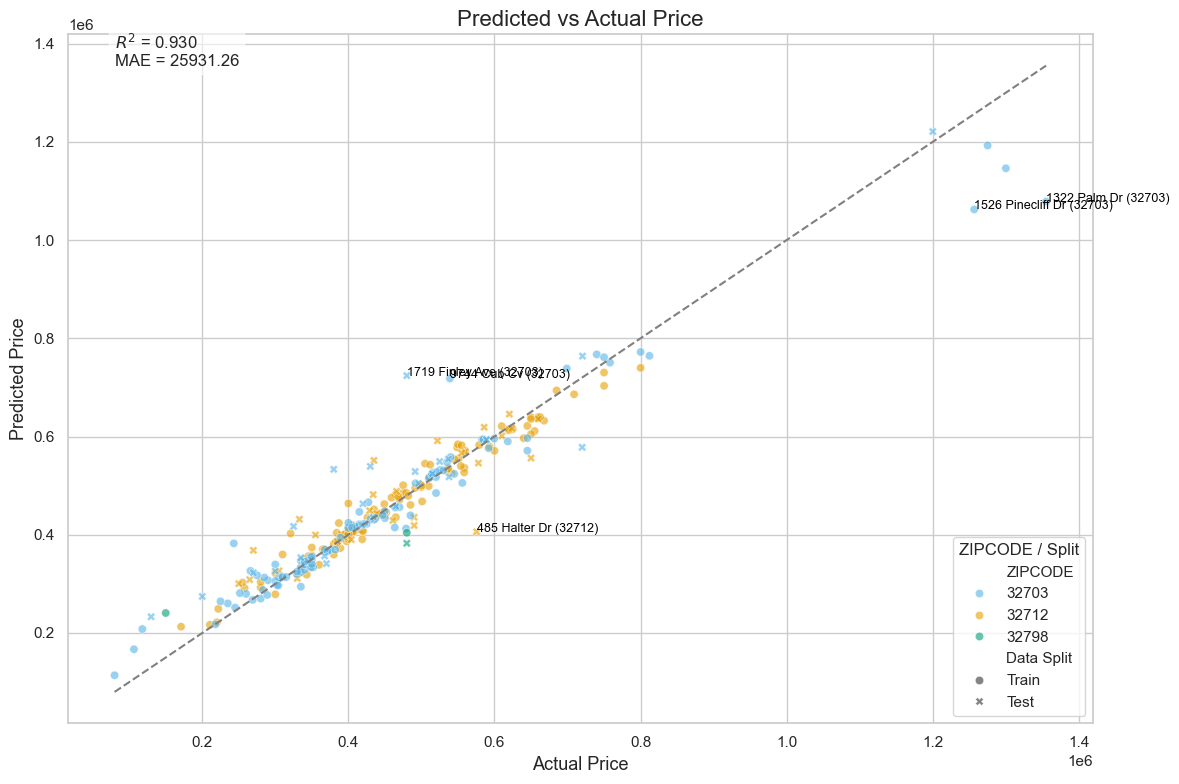

In [368]:
# Calculate metrics
r2 = r2_score(all_predictions['PRICE'], all_predictions['PredictedPrice'])
mae = mean_absolute_error(all_predictions['PRICE'], all_predictions['PredictedPrice'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['PRICE'] - all_predictions['PredictedPrice'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    32712: '#E69F00',  # orange
    32703: '#56B4E9',  # blue
    32798: '#009E73',  # green
}

# Plotting
plt.figure(figsize=(12, 8))

sns.scatterplot(
    data=all_predictions,
    x='PRICE',
    y='PredictedPrice',
    hue='ZIPCODE',
    style='Data Split',
    palette=color_palette,
    alpha=0.6
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['PRICE'].min(), all_predictions['PredictedPrice'].min())
max_val = max(all_predictions['PRICE'].max(), all_predictions['PredictedPrice'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice'],
             f"{row['ADDRESS']} ({row['ZIPCODE']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=13)
plt.ylabel('Predicted Price', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='ZIPCODE / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [370]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [372]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                       ADDRESS Data Split ZIPCODE   PRICE  PredictedPrice  \
266            1719 Finley Ave       Test   32703  480000        723972.0   
174                9744 Cub Cv      Train   32703  539000        718121.0   
260         1600 Crowncrest Dr       Test   32703  379995        533171.0   
189             226 N Lake Ave      Train   32703  243200        382379.0   
122           3922 Old Dunn Rd       Test   32712  435000        551293.0   
256  2016 Sanderlin Point Loop       Test   32703  430000        539181.0   
263            3772 Cochran St       Test   32703  130000        233050.0   
143          908 Hilly Bend Dr       Test   32712  333000        431586.0   
145            282 W Summit St       Test   32712  270000        368331.0   
271           1931 Clarcona Rd       Test   32703  325000        417004.0   

     ValuationDiff  
266       243972.0  
174       179121.0  
260       153176.0  
189       139179.0  
122       116293.0

In [374]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                   ADDRESS Data Split ZIPCODE    PRICE  PredictedPrice  \
153           1322 Palm Dr      Train   32703  1355000       1078381.0   
198      1526 Pinecliff Dr      Train   32703  1256627       1062243.0   
149          485 Halter Dr       Test   32712   575450        405939.0   
234      3141 Oak Alley Dr      Train   32703  1300000       1146016.0   
279        3630 Supreme Ct       Test   32703   720000        577970.0   
285   1507 Aurora Ridge Dr       Test   32798   479990        382643.0   
131     2332 Pond Cove Way       Test   32712   650000        556123.0   
237  6115 Linneal Beach Dr      Train   32703  1275000       1192589.0   
283   11155 Amber Ridge Dr      Train   32798   479990        404092.0   
253     1747 Crowncrest Dr      Train   32703   645000        571116.0   

     ValuationDiff  
153      -276619.0  
198      -194384.0  
149      -169511.0  
234      -153984.0  
279      -142030.0  
285       -97347.0  
131     

### Random Forest Regression with Cross-Validation for predicting sold prices.

In [379]:

# Function to train and predict for a specific ZIP code using cross-validation
def train_and_predict_cv(zipcode, features, cv=5):
    # Filter data for the specific ZIP code
    zipcode_data = df[df['ZIPCODE'] == zipcode].copy()
    
    if zipcode_data.empty:
        print(f"No data found for ZIP code: {zipcode}")
        return pd.DataFrame()

    X = zipcode_data[features].fillna(0)
    y = zipcode_data['PRICE'].fillna(0)

    # Initialize the model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)

    # Cross-validation strategy
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Get out-of-fold predictions (no leakage)
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Calculate CV MAE
    mae = mean_absolute_error(y, y_pred)
    print(f"\nZIP Code {zipcode} - Cross-Validated MAE: {mae:.2f}")

    # Fit the model on the full dataset to get final feature importances
    rf.fit(X, y)
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\nZIP Code {zipcode} - Feature Importances:")
    print(importance_df)

    # Store predictions
    zipcode_data['Data Split'] = 'CrossVal'
    zipcode_data['PredictedPrice'] = y_pred

    return zipcode_data[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']]

# Define feature set
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'GreatWaterViews']

# Get ZIP codes with 5 or more entries
valid_zips = df['ZIPCODE'].value_counts()
valid_zips = valid_zips[valid_zips >= 5].index

all_predictions_list = []

# Run cross-validation for each valid ZIP code
for zipcode in valid_zips:
    prediction_df = train_and_predict_cv(zipcode, features)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

# Combine all predictions
all_predictions = pd.concat(all_predictions_list, ignore_index=True)

# Save to CSV
output_path = "Data/Redfin_Apopka_CV.csv"
all_predictions.to_csv(output_path, index=False)


ZIP Code 32712 - Cross-Validated MAE: 43301.38

ZIP Code 32712 - Feature Importances:
           Feature  Importance
2      SQUARE FEET    0.796598
3         LOT SIZE    0.055180
4       YEAR BUILT    0.044552
7        LONGITUDE    0.030508
6         LATITUDE    0.022928
5        HOA/MONTH    0.020832
1            BATHS    0.020070
0             BEDS    0.009332
8  GreatWaterViews    0.000000

ZIP Code 32703 - Cross-Validated MAE: 73319.07

ZIP Code 32703 - Feature Importances:
           Feature  Importance
2      SQUARE FEET    0.534983
8  GreatWaterViews    0.177067
3         LOT SIZE    0.113069
4       YEAR BUILT    0.067749
0             BEDS    0.040084
6         LATITUDE    0.026369
7        LONGITUDE    0.016808
1            BATHS    0.012674
5        HOA/MONTH    0.011197


In [381]:
# Evaluate metrics by ZIP code
zipcode_metrics = []
for zipcode in all_predictions['ZIPCODE'].unique():
    subset = all_predictions[all_predictions['ZIPCODE'] == zipcode]
    r2 = r2_score(subset['PRICE'], subset['PredictedPrice'])
    mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
    zipcode_metrics.append({'ZIPCODE': zipcode, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Display metrics
zipcode_metrics_df = pd.DataFrame(zipcode_metrics)
print("\nPerformance Metrics by ZIP Code:")
print(zipcode_metrics_df)


Performance Metrics by ZIP Code:
   ZIPCODE     R²       MAE
0    32712  0.775  43301.38
1    32703  0.558  73319.07


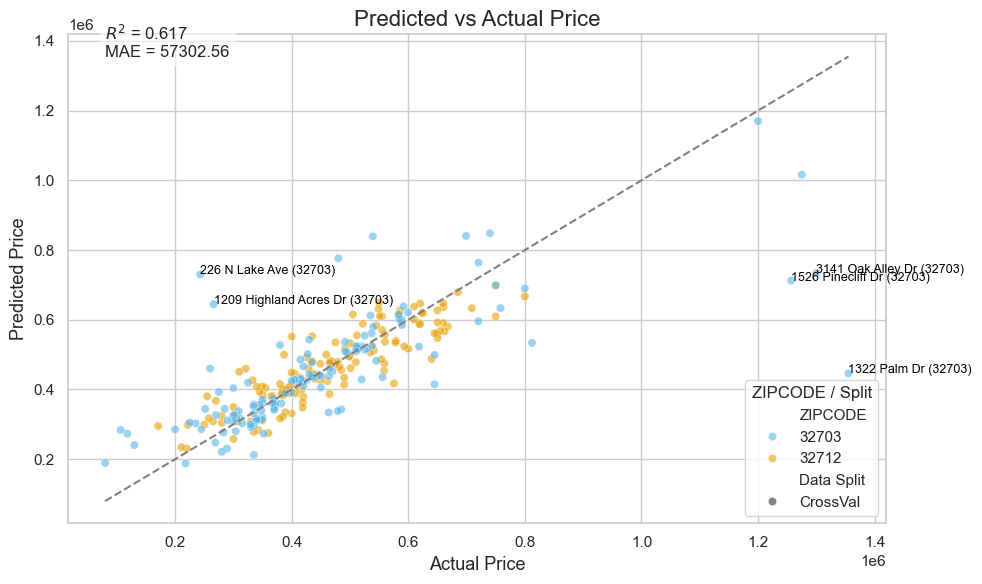

In [383]:
# Calculate metrics
r2 = r2_score(all_predictions['PRICE'], all_predictions['PredictedPrice'])
mae = mean_absolute_error(all_predictions['PRICE'], all_predictions['PredictedPrice'])

# Calculate residuals
all_predictions['Residual'] = np.abs(all_predictions['PRICE'] - all_predictions['PredictedPrice'])

# Get top 5 outliers
top_outliers = all_predictions.nlargest(5, 'Residual')

# Colorblind-friendly palette (Color Universal Design)
color_palette = {
    32712: '#E69F00',  # orange
    32703: '#56B4E9',  # blue
    32798: '#009E73',  # green
}

# Plotting
plt.figure(figsize=(10, 6))

sns.scatterplot(
    data=all_predictions,
    x='PRICE',
    y='PredictedPrice',
    hue='ZIPCODE',
    style='Data Split',
    palette=color_palette,
    alpha=0.6
)

# Diagonal line for reference (perfect prediction)
min_val = min(all_predictions['PRICE'].min(), all_predictions['PredictedPrice'].min())
max_val = max(all_predictions['PRICE'].max(), all_predictions['PredictedPrice'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice'],
             f"{row['ADDRESS']} ({row['ZIPCODE']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=13)
plt.ylabel('Predicted Price', fontsize=13)

# Display R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"$R^2$ = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Legend and layout
plt.legend(title='ZIPCODE / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [385]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [387]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                    ADDRESS Data Split ZIPCODE   PRICE  PredictedPrice  \
274          226 N Lake Ave   CrossVal   32703  243200      730234.310   
270  1209 Highland Acres Dr   CrossVal   32703  266000      644544.790   
176             9744 Cub Cv   CrossVal   32703  539000      839256.815   
195         1719 Finley Ave   CrossVal   32703  480000      776426.980   
271          406 Jillson St   CrossVal   32703  260000      459758.975   
281         249 S McGee Ave   CrossVal   32703  106500      283717.000   
280  3000 Clarcona Rd #2828   CrossVal   32703  118000      273324.685   
100    2313 Park Village Pl   CrossVal   32712  400000      551791.015   
227      1600 Crowncrest Dr   CrossVal   32703  379995      527387.905   
163           1065 Cavan Dr   CrossVal   32703  699000      840656.680   

     ValuationDiff  
274     487034.310  
270     378544.790  
176     300256.815  
195     296426.980  
271     199758.975  
281     177217.000  
280     1

In [389]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                   ADDRESS Data Split ZIPCODE    PRICE  PredictedPrice  \
151           1322 Palm Dr   CrossVal   32703  1355000      446232.300   
152      3141 Oak Alley Dr   CrossVal   32703  1300000      734052.670   
154      1526 Pinecliff Dr   CrossVal   32703  1256627      712203.170   
156    650 Creeping Fig St   CrossVal   32703   812160      533574.520   
153  6115 Linneal Beach Dr   CrossVal   32703  1275000     1016345.150   
165     1747 Crowncrest Dr   CrossVal   32703   645000      414852.295   
30           485 Halter Dr   CrossVal   32712   575450      417438.935   
16          2509 Dowman Dr   CrossVal   32712   640000      487392.550   
164       1433 Stoneway Pl   CrossVal   32703   645000      498935.150   
194          8100 Stone Rd   CrossVal   32703   485000      343038.540   

     ValuationDiff  
151    -908767.700  
152    -565947.330  
154    -544423.830  
156    -278585.480  
153    -258654.850  
165    -230147.705  
30     -

### Combined CV + Full-Training Prediction Function

In [394]:
def train_and_predict_cv_and_ft(zipcode, features, cv=5):
    # Filter data for the specific ZIP code
    zipcode_data = df[df['ZIPCODE'] == zipcode].copy()

    if zipcode_data.empty:
        print(f"No data found for ZIP code: {zipcode}")
        return pd.DataFrame()

    X = zipcode_data[features].fillna(0)
    y = zipcode_data['PRICE'].fillna(0)

    rf = RandomForestRegressor(n_estimators=200, max_depth=20, max_features='sqrt', random_state=42)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Cross-Validation Predictions
    y_pred_cv = cross_val_predict(rf, X, y, cv=kf)
    mae_cv = mean_absolute_error(y, y_pred_cv)
    r2_cv = r2_score(y, y_pred_cv)
    print(f"\nZIP {zipcode} - CV MAE: {mae_cv:.2f}, R²: {r2_cv:.3f}")

    # Full Training Predictions
    rf.fit(X, y)
    y_pred_ft = rf.predict(X)
    mae_ft = mean_absolute_error(y, y_pred_ft)
    r2_ft = r2_score(y, y_pred_ft)
    print(f"ZIP {zipcode} - Full Model MAE: {mae_ft:.2f}, R²: {r2_ft:.3f}")

    # Feature importances
    importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    print(f"\nZIP {zipcode} - Feature Importances:")
    print(importance_df)

    # Cross-validated prediction dataframe
    cv_df = zipcode_data.copy()
    cv_df['PredictedPrice'] = np.round(y_pred_cv, 2)
    cv_df['Data Split'] = 'CrossVal'

    # Full model prediction dataframe
    ft_df = zipcode_data.copy()
    ft_df['PredictedPrice'] = np.round(y_pred_ft, 2)
    ft_df['Data Split'] = 'FullTrain'

    # Combine both into one dataframe
    combined_df = pd.concat([cv_df, ft_df], ignore_index=True)

    # Return consistent column structure
    return combined_df[['ADDRESS', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'Data Split']]

# Define your feature list
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'HOA/MONTH', 'LATITUDE', 'LONGITUDE', 'GreatWaterViews']

# Get ZIP codes with sufficient samples
valid_zips = df['ZIPCODE'].value_counts()
valid_zips = valid_zips[valid_zips >= 5].index

all_predictions_list = []

# Run predictions for each ZIP code
for zipcode in valid_zips:
    prediction_df = train_and_predict_cv_and_ft(zipcode, features)
    if not prediction_df.empty:
        all_predictions_list.append(prediction_df)

# Combine all predictions
all_predictions = pd.concat(all_predictions_list, ignore_index=True)

# Initialize note column if you want to add flags
all_predictions['Note'] = ''

# Optionally apply overrides (e.g., flagged homes, missing features)
# override_dict = {
#     '123 Main St': {'price': 0, 'note': 'Invalid listing'},
# }

# for address, override in override_dict.items():
#     all_predictions.loc[all_predictions['ADDRESS'] == address, 'PredictedPrice'] = override['price']
#     all_predictions.loc[all_predictions['ADDRESS'] == address, 'Note'] = override['note']
side_by_side = all_predictions.pivot_table(
    index=['ADDRESS', 'ZIPCODE', 'PRICE'],
    columns='Data Split',
    values='PredictedPrice'
).reset_index()

# Rename columns for clarity
side_by_side = side_by_side.rename(columns={
    'CrossVal': 'PredictedPrice_CV',
    'FullTrain': 'PredictedPrice_FT'
})

# Optional: Calculate residuals for both
side_by_side['Residual_CV'] = np.abs(side_by_side['PRICE'] - side_by_side['PredictedPrice_CV']).round(0)
side_by_side['Residual_FT'] = np.abs(side_by_side['PRICE'] - side_by_side['PredictedPrice_FT']).round(0)

# Save or inspect the wide-format DataFrame
side_by_side.to_csv("Data/Redfin_Apopka_CVFT.csv", index=False)

# Save predictions
# output_path = "Data/Redfin_Apopka_CV_and_FT.csv"
# all_predictions.to_csv(output_path, index=False)


ZIP 32712 - CV MAE: 44067.68, R²: 0.757
ZIP 32712 - Full Model MAE: 16170.53, R²: 0.967

ZIP 32712 - Feature Importances:
           Feature  Importance
2      SQUARE FEET    0.431381
1            BATHS    0.155790
0             BEDS    0.114041
3         LOT SIZE    0.082405
4       YEAR BUILT    0.072343
7        LONGITUDE    0.055403
5        HOA/MONTH    0.046150
6         LATITUDE    0.042487
8  GreatWaterViews    0.000000

ZIP 32703 - CV MAE: 72535.20, R²: 0.567
ZIP 32703 - Full Model MAE: 24046.85, R²: 0.951

ZIP 32703 - Feature Importances:
           Feature  Importance
2      SQUARE FEET    0.332591
8  GreatWaterViews    0.150099
3         LOT SIZE    0.107478
1            BATHS    0.095792
4       YEAR BUILT    0.093062
0             BEDS    0.083602
7        LONGITUDE    0.057608
6         LATITUDE    0.045094
5        HOA/MONTH    0.034675


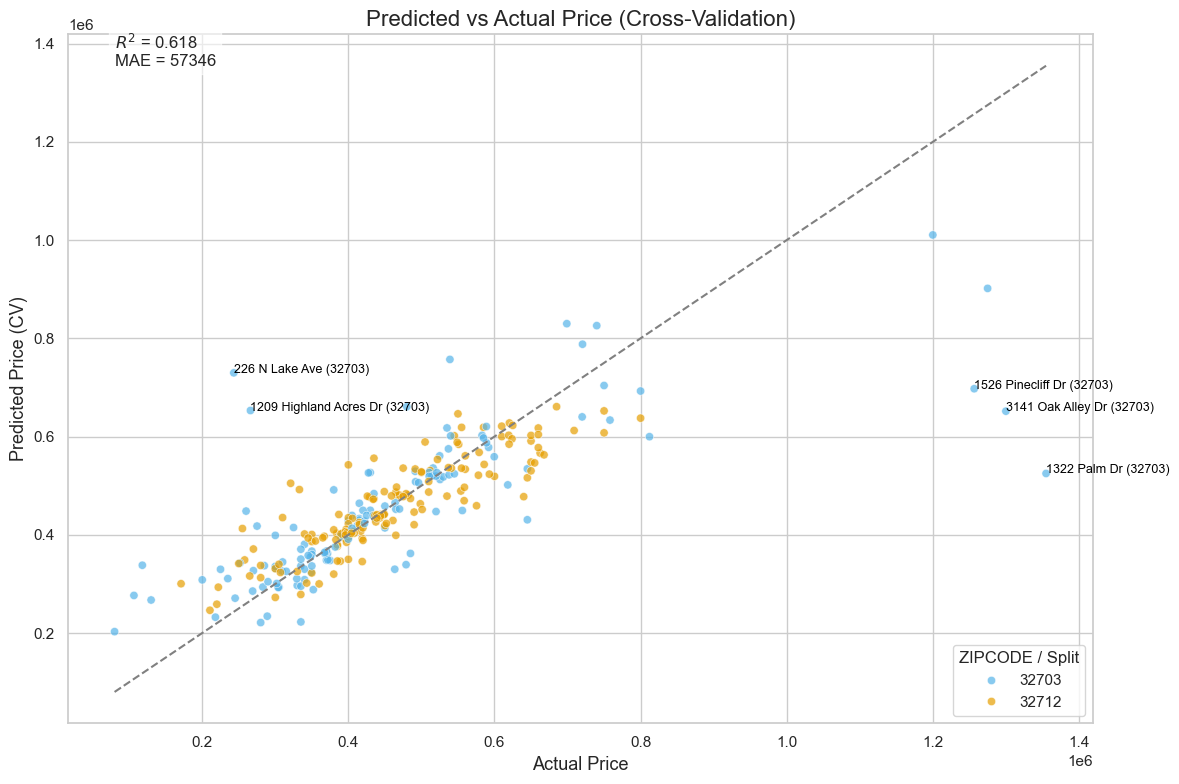

In [396]:
# CV metrics
r2_cv = r2_score(side_by_side['PRICE'], side_by_side['PredictedPrice_CV'])
mae_cv = mean_absolute_error(side_by_side['PRICE'], side_by_side['PredictedPrice_CV'])

# CV residuals
side_by_side['Residual_CV'] = np.abs(side_by_side['PRICE'] - side_by_side['PredictedPrice_CV'])
top_outliers_cv = side_by_side.nlargest(5, 'Residual_CV')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=side_by_side,
    x='PRICE',
    y='PredictedPrice_CV',
    hue='ZIPCODE',
    palette=color_palette,
    alpha=0.7
)

# Diagonal line for perfect prediction reference
min_val = min(side_by_side['PRICE'].min(), side_by_side['PredictedPrice_CV'].min())
max_val = max(side_by_side['PRICE'].max(), side_by_side['PredictedPrice_CV'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

# Annotate top 5 residual outliers
for _, row in top_outliers_cv.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice_CV'],
             f"{row['ADDRESS']} ({row['ZIPCODE']})", fontsize=9, color='black')

# Labels and title
plt.title('Predicted vs Actual Price (Cross-Validation)', fontsize=16)
plt.xlabel('Actual Price', fontsize=13)
plt.ylabel('Predicted Price (CV)', fontsize=13)

# Display R² and MAE
plt.text(min_val + 5, max_val - 25,
         f"$R^2$ = {r2_cv:.3f}\nMAE = {mae_cv:.0f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.6))

# Optional: Legend (only if using hue/style)
plt.legend(title='ZIPCODE / Split', loc='lower right')
plt.tight_layout()
plt.show()

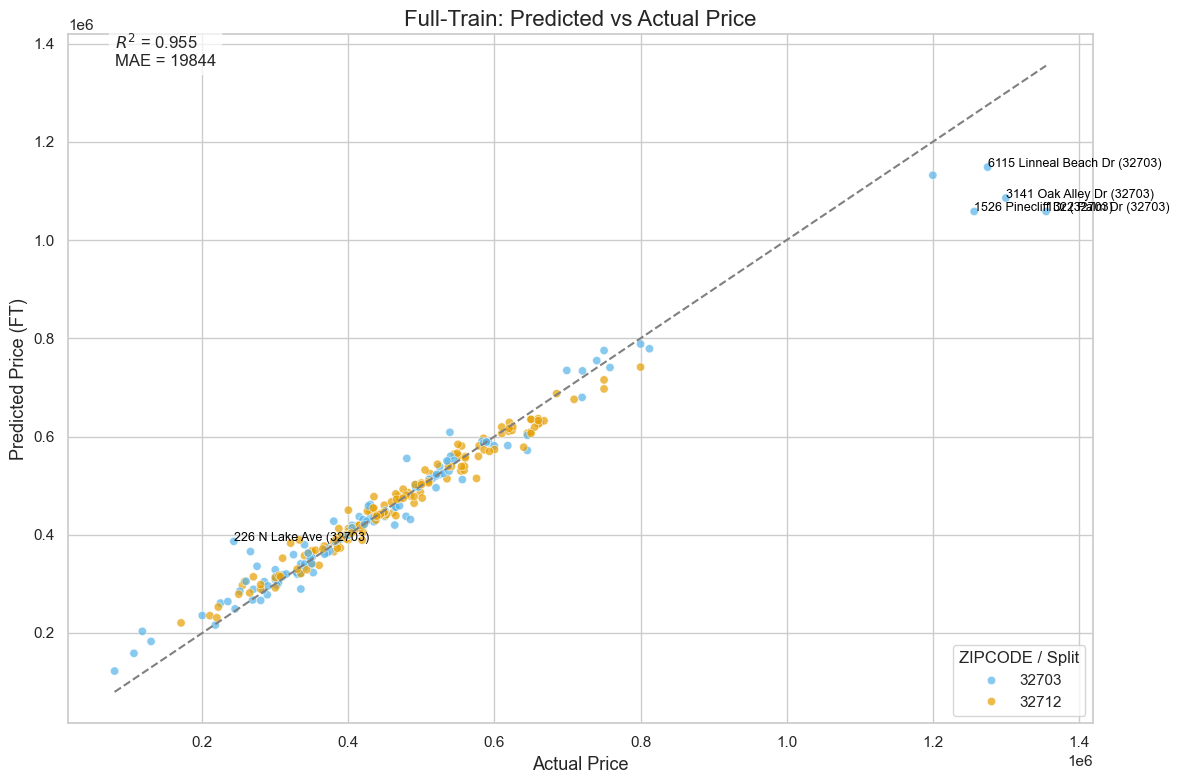

In [398]:
# FT metrics
r2_ft = r2_score(side_by_side['PRICE'], side_by_side['PredictedPrice_FT'])
mae_ft = mean_absolute_error(side_by_side['PRICE'], side_by_side['PredictedPrice_FT'])

# FT residuals
side_by_side['Residual_FT'] = np.abs(side_by_side['PRICE'] - side_by_side['PredictedPrice_FT'])
top_outliers_ft = side_by_side.nlargest(5, 'Residual_FT')

plt.figure(figsize=(12, 8))
sns.scatterplot(
    data=side_by_side,
    x='PRICE',
    y='PredictedPrice_FT',
    hue='ZIPCODE',
    palette=color_palette,
    alpha=0.7
)

min_val = min(side_by_side['PRICE'].min(), side_by_side['PredictedPrice_FT'].min())
max_val = max(side_by_side['PRICE'].max(), side_by_side['PredictedPrice_FT'].max())
plt.plot([min_val, max_val], [min_val, max_val], ls="--", color='gray')

for _, row in top_outliers_ft.iterrows():
    plt.text(row['PRICE'] + 2, row['PredictedPrice_FT'],
             f"{row['ADDRESS']} ({row['ZIPCODE']})", fontsize=9, color='black')

plt.title('Full-Train: Predicted vs Actual Price', fontsize=16)
plt.xlabel('Actual Price', fontsize=13)
plt.ylabel('Predicted Price (FT)', fontsize=13)
plt.text(min_val + 10, max_val - 30,
         f"$R^2$ = {r2_ft:.3f}\nMAE = {mae_ft:.0f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.7))
plt.legend(title='ZIPCODE / Split', loc='lower right')
plt.tight_layout()
plt.show()

In [400]:
all_predictions['ValuationDiff'] = all_predictions['PredictedPrice'] - all_predictions['PRICE']

In [402]:
overvalued = all_predictions.sort_values(by='ValuationDiff', ascending=False).head(10)
print("Most Over-Valued Properties:")
print(overvalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Over-Valued Properties:
                    ADDRESS Data Split ZIPCODE   PRICE  PredictedPrice  \
425          226 N Lake Ave   CrossVal   32703  243200       729735.76   
421  1209 Highland Acres Dr   CrossVal   32703  266000       653002.60   
431  3000 Clarcona Rd #2828   CrossVal   32703  118000       337992.71   
327             9744 Cub Cv   CrossVal   32703  539000       757045.55   
422          406 Jillson St   CrossVal   32703  260000       448217.45   
134         191 Caldwell St   CrossVal   32712  321000       504860.77   
346         1719 Finley Ave   CrossVal   32703  480000       660712.39   
432         249 S McGee Ave   CrossVal   32703  106500       276492.00   
132       908 Hilly Bend Dr   CrossVal   32712  333000       492033.71   
145    1131 Orange Grove Ln   CrossVal   32712  255000       412719.12   

     ValuationDiff  
425      486535.76  
421      387002.60  
431      219992.71  
327      218045.55  
422      188217.45  
134      183860.77  
346      

In [404]:
undervalued = all_predictions.sort_values(by='ValuationDiff').head(10)
print("Most Under-Valued Properties:")
print(undervalued[['ADDRESS', 'Data Split', 'ZIPCODE', 'PRICE', 'PredictedPrice', 'ValuationDiff']])

Most Under-Valued Properties:
                   ADDRESS Data Split ZIPCODE    PRICE  PredictedPrice  \
302           1322 Palm Dr   CrossVal   32703  1355000       524850.66   
303      3141 Oak Alley Dr   CrossVal   32703  1300000       651637.77   
305      1526 Pinecliff Dr   CrossVal   32703  1256627       697364.60   
304  6115 Linneal Beach Dr   CrossVal   32703  1275000       901677.30   
434           1322 Palm Dr  FullTrain   32703  1355000      1058210.00   
316     1747 Crowncrest Dr   CrossVal   32703   645000       430523.65   
435      3141 Oak Alley Dr  FullTrain   32703  1300000      1085535.57   
307    650 Creeping Fig St   CrossVal   32703   812160       599720.72   
437      1526 Pinecliff Dr  FullTrain   32703  1256627      1058160.18   
306      5203 Pineview Way   CrossVal   32703  1200000      1010497.44   

     ValuationDiff  
302     -830149.34  
303     -648362.23  
305     -559262.40  
304     -373322.70  
434     -296790.00  
316     -214476.35  
435     

In [406]:
'''
### Random Forest Regression for addresses only instead of filtered by ZipCode.
def train_and_predict_address(features):
    # Prepare X and y from the full dataset
    X = df[features].fillna(0)
    y = df['PRICE'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    data = df.reset_index(drop=True).copy()

    # Split and get indices
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, data.index, test_size=0.2, random_state=42
    )

    data.loc[idx_train, 'Data Split'] = 'Train'
    data.loc[idx_test, 'Data Split'] = 'Test'

    # Train model
    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)
    rf.fit(X_train, y_train)

    # Predict
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train)}")
    print(f"Testing MAE: {mean_absolute_error(y_test, y_pred_test)}")

    # Feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print("\nFeature Importances:")
    print(importance_df)

    # Store predictions
    train_df = data.loc[idx_train, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    train_df['Data Split'] = 'Train'
    train_df['PredictedPrice'] = y_pred_train

    test_df = data.loc[idx_test, ['ADDRESS', 'ZIPCODE', 'PRICE']].copy()
    test_df['Data Split'] = 'Test'
    test_df['PredictedPrice'] = y_pred_test

    return pd.concat([train_df, test_df], ignore_index=True).round(0)

features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT', 'LATITUDE', 'LONGITUDE']

all_predictions = train_and_predict_address(features)

# Save output
output_path = "Data/Redfin_Apopka_Address.csv"
all_predictions[['ADDRESS', 'Data Split', 'ZIPCODE', 'PredictedPrice', 'PRICE']].to_csv(output_path, index=False)
'''

'\n### Random Forest Regression for addresses only instead of filtered by ZipCode.\ndef train_and_predict_address(features):\n    # Prepare X and y from the full dataset\n    X = df[features].fillna(0)\n    y = df[\'PRICE\'].fillna(0)\n\n    # Reset index to preserve alignment\n    X = X.reset_index(drop=True)\n    y = y.reset_index(drop=True)\n    data = df.reset_index(drop=True).copy()\n\n    # Split and get indices\n    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(\n        X, y, data.index, test_size=0.2, random_state=42\n    )\n\n    data.loc[idx_train, \'Data Split\'] = \'Train\'\n    data.loc[idx_test, \'Data Split\'] = \'Test\'\n\n    # Train model\n    rf = RandomForestRegressor(n_estimators=200, max_depth=20, random_state=42)\n    rf.fit(X_train, y_train)\n\n    # Predict\n    y_pred_train = rf.predict(X_train)\n    y_pred_test = rf.predict(X_test)\n\n    print(f"Training MAE: {mean_absolute_error(y_train, y_pred_train)}")\n    print(f"Testing MAE:

In [408]:
'''
address_metrics = []

for addr in all_predictions['ADDRESS'].unique():
    subset = all_predictions[all_predictions['ADDRESS'] == addr]

    # Only calculate if we have both actual and predicted
    if not subset['PRICE'].isnull().all() and not subset['PredictedPrice'].isnull().all():
        mae = mean_absolute_error(subset['PRICE'], subset['PredictedPrice'])
        address_metrics.append({
            'ADDRESS': addr,
            'MAE': round(mae, 2)
        })

# Convert to DataFrame for easy viewing
address_metrics_df = pd.DataFrame(address_metrics)

print("\nPerformance Metrics by ADDRESS:")
print(address_metrics_df)
'''

'\naddress_metrics = []\n\nfor addr in all_predictions[\'ADDRESS\'].unique():\n    subset = all_predictions[all_predictions[\'ADDRESS\'] == addr]\n\n    # Only calculate if we have both actual and predicted\n    if not subset[\'PRICE\'].isnull().all() and not subset[\'PredictedPrice\'].isnull().all():\n        mae = mean_absolute_error(subset[\'PRICE\'], subset[\'PredictedPrice\'])\n        address_metrics.append({\n            \'ADDRESS\': addr,\n            \'MAE\': round(mae, 2)\n        })\n\n# Convert to DataFrame for easy viewing\naddress_metrics_df = pd.DataFrame(address_metrics)\n\nprint("\nPerformance Metrics by ADDRESS:")\nprint(address_metrics_df)\n'

In [410]:
'''
# A more simpler way (Random Forest Regression for Housing Price Prediction with Feature Importance Analysis)
# --- Step 1: Select relevant columns ---
features = ['BEDS', 'BATHS', 'SQUARE FEET', 'LOT SIZE', 'YEAR BUILT',
            'LATITUDE', 'LONGITUDE']
target = 'PRICE'

# Make a copy of only the relevant data
df_model = df[features + [target]].copy()

# --- Step 2: Drop rows with missing values ---
df_model = df_model.dropna()

# --- Step 3: Train-test split ---
X = df_model[features]
y = df_model[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- Step 4: Train Random Forest Regressor ---
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# --- Step 5: Predict and Evaluate ---
y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"MAE: ${mae:,.2f}")
print(f"RMSE: ${rmse:,.2f}")

# --- Step 6: Feature Importance Plot ---
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar([features[i] for i in indices], importances[indices])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
'''

'\n# A more simpler way (Random Forest Regression for Housing Price Prediction with Feature Importance Analysis)\n# --- Step 1: Select relevant columns ---\nfeatures = [\'BEDS\', \'BATHS\', \'SQUARE FEET\', \'LOT SIZE\', \'YEAR BUILT\',\n            \'LATITUDE\', \'LONGITUDE\']\ntarget = \'PRICE\'\n\n# Make a copy of only the relevant data\ndf_model = df[features + [target]].copy()\n\n# --- Step 2: Drop rows with missing values ---\ndf_model = df_model.dropna()\n\n# --- Step 3: Train-test split ---\nX = df_model[features]\ny = df_model[target]\n\nX_train, X_test, y_train, y_test = train_test_split(\n    X, y, test_size=0.2, random_state=42\n)\n\n# --- Step 4: Train Random Forest Regressor ---\nmodel = RandomForestRegressor(n_estimators=100, random_state=42)\nmodel.fit(X_train, y_train)\n\n# --- Step 5: Predict and Evaluate ---\ny_pred = model.predict(X_test)\n\nmae = mean_absolute_error(y_test, y_pred)\nrmse = root_mean_squared_error(y_test, y_pred)\n\nprint(f"MAE: ${mae:,.2f}")\nprint